# **YOLOv8을 이용한 교통 표지판 인식**

자료 출처: https://www.kaggle.com/code/seokhwanyang/traffic-signs-detection-using-yolov8/edit

- 데이터 업로드

In [7]:
import gdown
import os

In [2]:
train_image_id = '1aCHDE2smAaqxQ29-3m1PM_w-eytuyx69'
gdown.download(id=train_image_id, output='./traffic_sign_dataset.zip')
os.system("unzip ./traffic_sign_dataset.zip")

Downloading...
From (original): https://drive.google.com/uc?id=1aCHDE2smAaqxQ29-3m1PM_w-eytuyx69
From (redirected): https://drive.google.com/uc?id=1aCHDE2smAaqxQ29-3m1PM_w-eytuyx69&confirm=t&uuid=91f3c7c1-4ed7-44b4-8014-977c278f319c
To: /content/traffic_sign_dataset.zip
100%|██████████| 105M/105M [00:01<00:00, 56.9MB/s] 


0

## **1. 필수 라이브러리**

### 1.1 ultralytics 설치


- ultralytics: YOLO 패키지 지원 패키지

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.6 MB/s eta 0:00:00


### 1.2 기본 패키지

- pathlib
    - 파일이나 디렉터리(폴더) 경로를 다루는 데 사용하는 모듈
    - os.path 모듈과 달리 경로를 객체 형태로 조작할 수 있게 해주는 것이 가장 큰 특징
- glob
    - 파이썬 코드 안에서 파일들을 검색하고 목록으로 가져올 수 있게 해주는 모듈
    - 특정 패턴을 가진 파일 경로를 찾을 때 흔히 사용되는 편리한 도구

In [1]:
import os
import pathlib
import glob
import random

### 1.3 데이터 처리용 패키지

In [2]:
import numpy as np
import pandas as pd

### 1.4 시각화 처리용 패키지

In [3]:
import matplotlib.pyplot as plt

- seaborn 패키지 가져오기 및 외형 설정
    - seaborn: 시각화 디자인 업그레이드를 위한 패키지

In [4]:
import seaborn as sns
sns.set(rc={'axes.facecolor': '#eae8fa'}, style='darkgrid')

### 1.5 개발환경 보완용 패키지

- IPython.display
    - Video
        - Jupyter Notebook 환경에서 코드 셀 안에 동영상 파일을 직접 임베드하여 재생할 수 있게 해줌
- tqdm.notebook
    - tqdm
        - 반복문(loop)의 진행 상황을 진행률 바(progress bar) 형태로 시각적으로 보여줌
    - trange
        - tqdm(range(N))의 단축 표현
        - 주로 특정 횟수만큼 반복되는 반복문의 진행 상황을 표시할 때 range() 함수와 함께 편리하게 사용


In [5]:
from IPython.display import Video
from tqdm.notebook import trange, tqdm

### 1.6 영상처리용 패키지

In [6]:
import cv2
from PIL import Image
from ultralytics import YOLO

### 1.7 기타 처리

- 불필요한 경고 메시지 제거

In [7]:
import warnings
warnings.filterwarnings('ignore')

## **2. 데이터셋**

### 2.1 감지 전 원본 이미지 보여주기

- 훈련 데이터셋으로부터 예시 이미지 확인

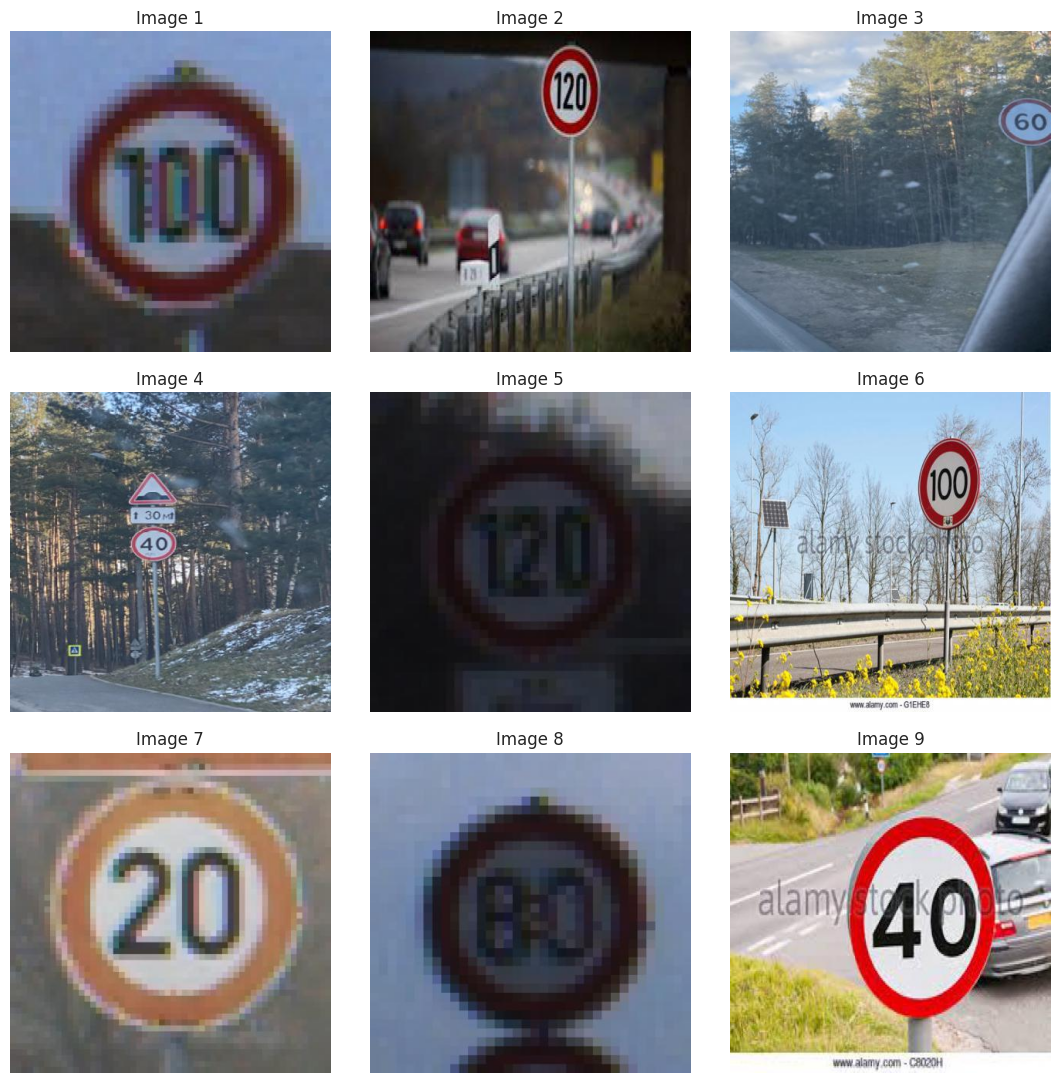

In [11]:
Image_dir = './car/train/images'

num_samples = 9
image_files = os.listdir(Image_dir)

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### 2.2 훈련 단계에서 사용할 이미지 모양 가져오기

In [12]:
# Get the size of the image
image = cv2.imread("./car/train/images/00000_00000_00012_png.rf.23f94508dba03ef2f8bd187da2ec9c26.jpg")
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 416x416 and 3 channels.


## **3. 사전학습된 YOLOv8 모델**


image 1/1 /content/car/train/images/FisheyeCamera_1_00228_png.rf.e7c43ee9b922f7b2327b8a00ccf46a4c.jpg: 640x640 (no detections), 8.0ms
Speed: 11.3ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


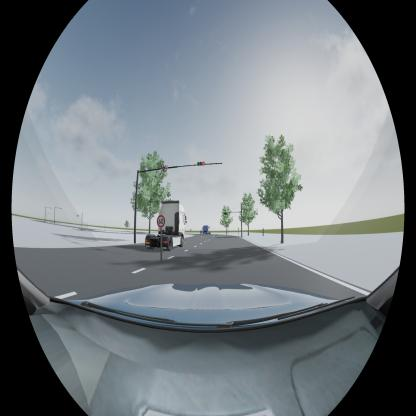

In [13]:
# Use a pretrained YOLOv8n model
model = YOLO("yolov8n.pt")

# Use the model to detect object
image = "./car/train/images/FisheyeCamera_1_00228_png.rf.e7c43ee9b922f7b2327b8a00ccf46a4c.jpg"
result_predict = model.predict(source = image, imgsz=(640))

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

## **4. YOLOv8 기반 교통 표지판 감지 모델**

### 4.1 기본 설정

In [14]:
!pip install --upgrade ultralytics ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1


In [15]:
# Build from YAML and transfer weights
Final_model = YOLO('yolov8n.pt')

# Training The Final Model
Result_Final_model = Final_model.train(data="./car/data.yaml",epochs = 30, batch = -1, optimizer = 'auto')

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./car/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrain

### 4.2 검증 단계

In [14]:
import os
import cv2
import matplotlib.pyplot as plt

In [23]:
def display_images(post_training_files_path, image_files):

    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        print(image_path)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [24]:
# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'BoxF1_curve.png',
    'BoxP_curve.png',
    'BoxR_curve.png',
    'BoxPR_curve.png',
    'results.png'
]

In [25]:
# Path to the directory containing the images
post_training_files_path = './runs/detect/train'

./runs/detect/train/confusion_matrix_normalized.png


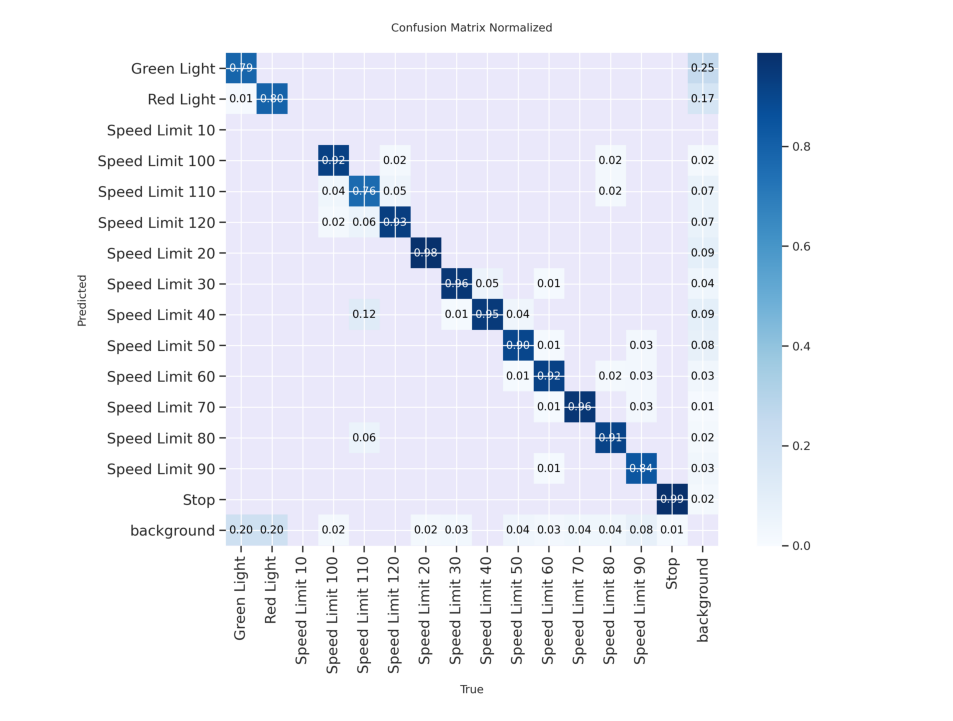

./runs/detect/train/BoxF1_curve.png


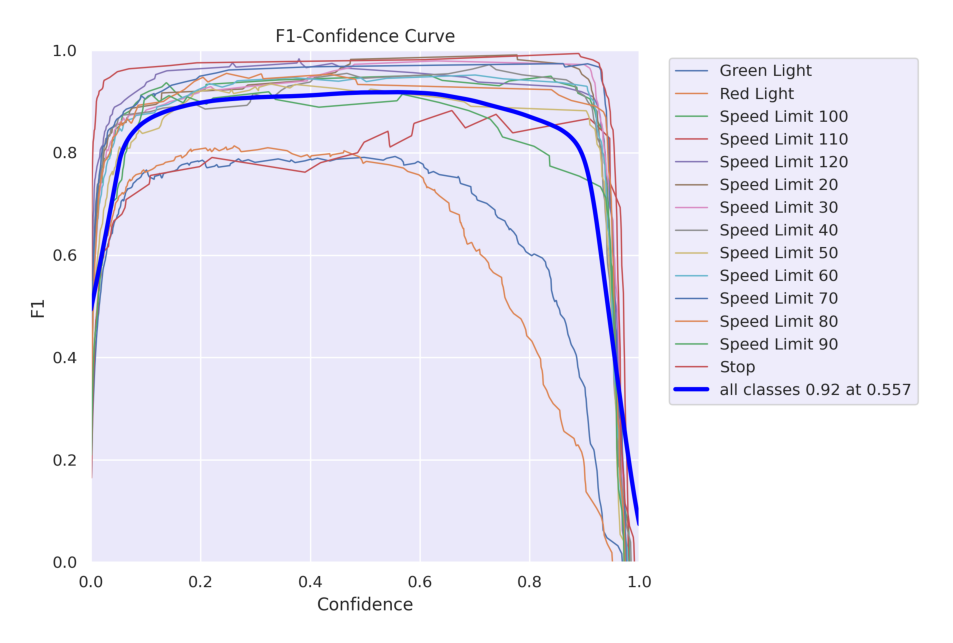

./runs/detect/train/BoxP_curve.png


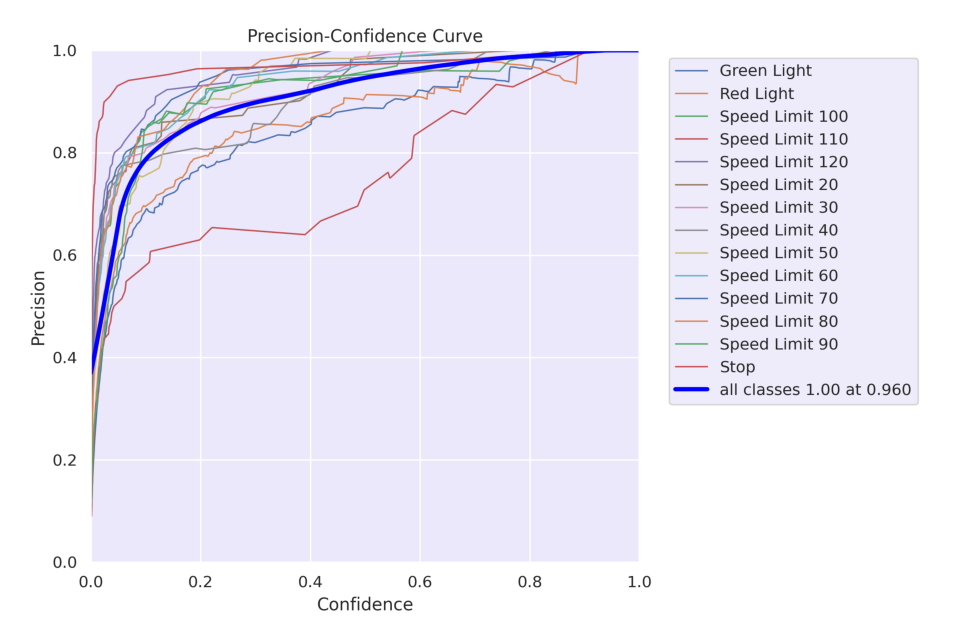

./runs/detect/train/BoxR_curve.png


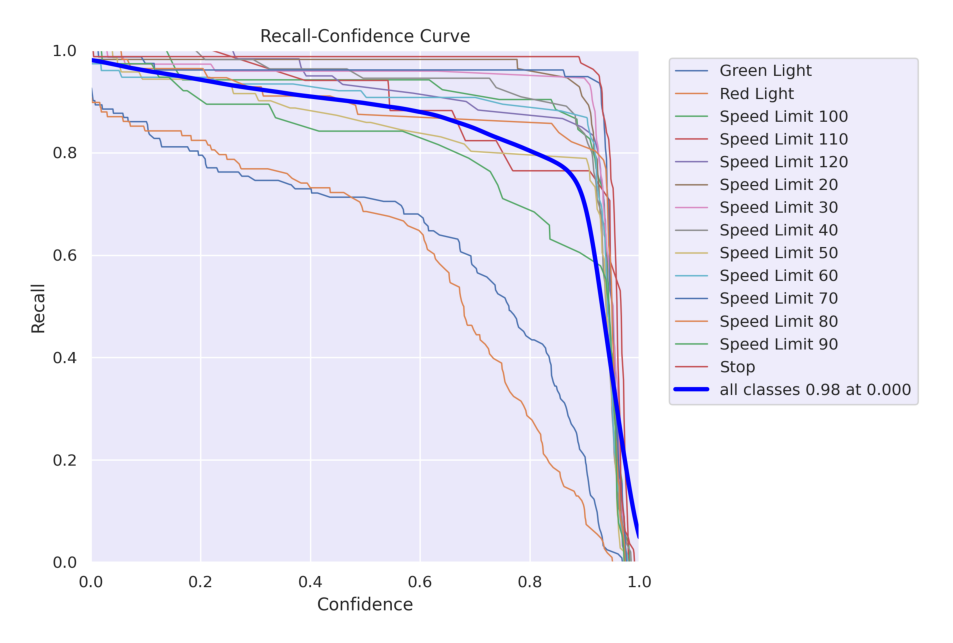

./runs/detect/train/BoxPR_curve.png


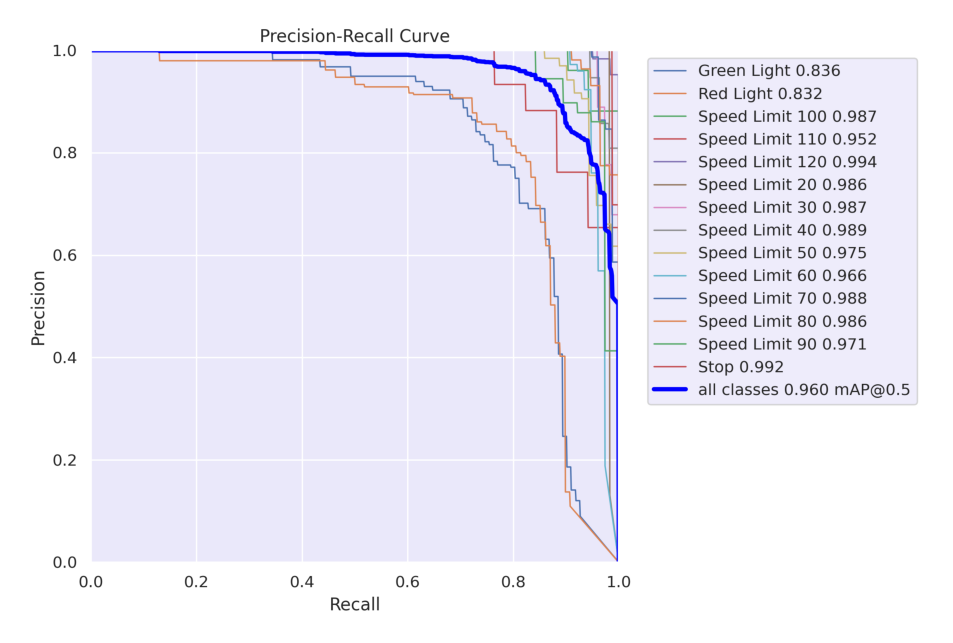

./runs/detect/train/results.png


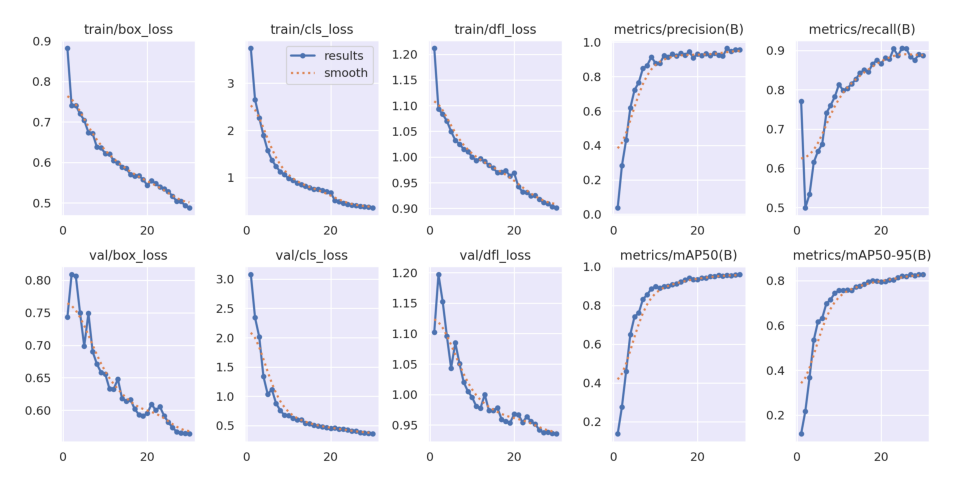

In [26]:
# Display the images
display_images(post_training_files_path, image_files)

In [27]:
Result_Final_model = pd.read_csv('./runs/detect/train/results.csv')
Result_Final_model.tail(10)

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
20     21  1332.07         0.55514         0.51236         0.94222   
21     22  1390.85         0.54780         0.49077         0.93199   
22     23  1448.48         0.53989         0.45799         0.93142   
23     24  1507.90         0.53490         0.43730         0.92417   
24     25  1565.97         0.52842         0.41991         0.92537   
25     26  1624.01         0.51676         0.40749         0.91780   
26     27  1683.62         0.50409         0.39320         0.91191   
27     28  1740.15         0.50394         0.38592         0.90912   
28     29  1799.11         0.49342         0.37543         0.90331   
29     30  1856.95         0.48843         0.36354         0.90136   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
20               0.92231            0.88139           0.94218   
21               0.93354            0.87770           0.94227   
22               0.92321            0.90439           0.95020   
23               0.93665            0.88708           0.95002   
24               0.92347            0.90559           0.95621   
25               0.91887            0.90436           0.95072   
26               0.96447            0.88397           0.95621   
27               0.94588            0.87563           0.95305   
28               0.95584            0.89030           0.95741   
29               0.95584            0.88727           0.96006   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
20              0.79662       0.60923       0.46091       0.96705  0.000179   
21              0.80388       0.59988       0.43966       0.95432  0.000161   
22              0.80325       0.60513       0.44347       0.96369  0.000144   
23              0.81298       0.59128       0.42458       0.95593  0.000127   
24              0.82045       0.58132       0.40892       0.95141  0.000109   
25              0.81909       0.57293       0.40544       0.94167  0.000092   
26              0.82726       0.56674       0.38354       0.93745  0.000075   
27              0.82187       0.56461       0.37699       0.93797  0.000057   
28              0.82708       0.56434       0.36566       0.93650  0.000040   
29              0.82792       0.56363       0.36084       0.93560  0.000023   

      lr/pg1    lr/pg2  
20  0.000179  0.000179  
21  0.000161  0.000161  
22  0.000144  0.000144  
23  0.000127  0.000127  
24  0.000109  0.000109  
25  0.000092  0.000092  
26  0.000075  0.000075  
27  0.000057  0.000057  
28  0.000040  0.000040  
29  0.000023  0.000023

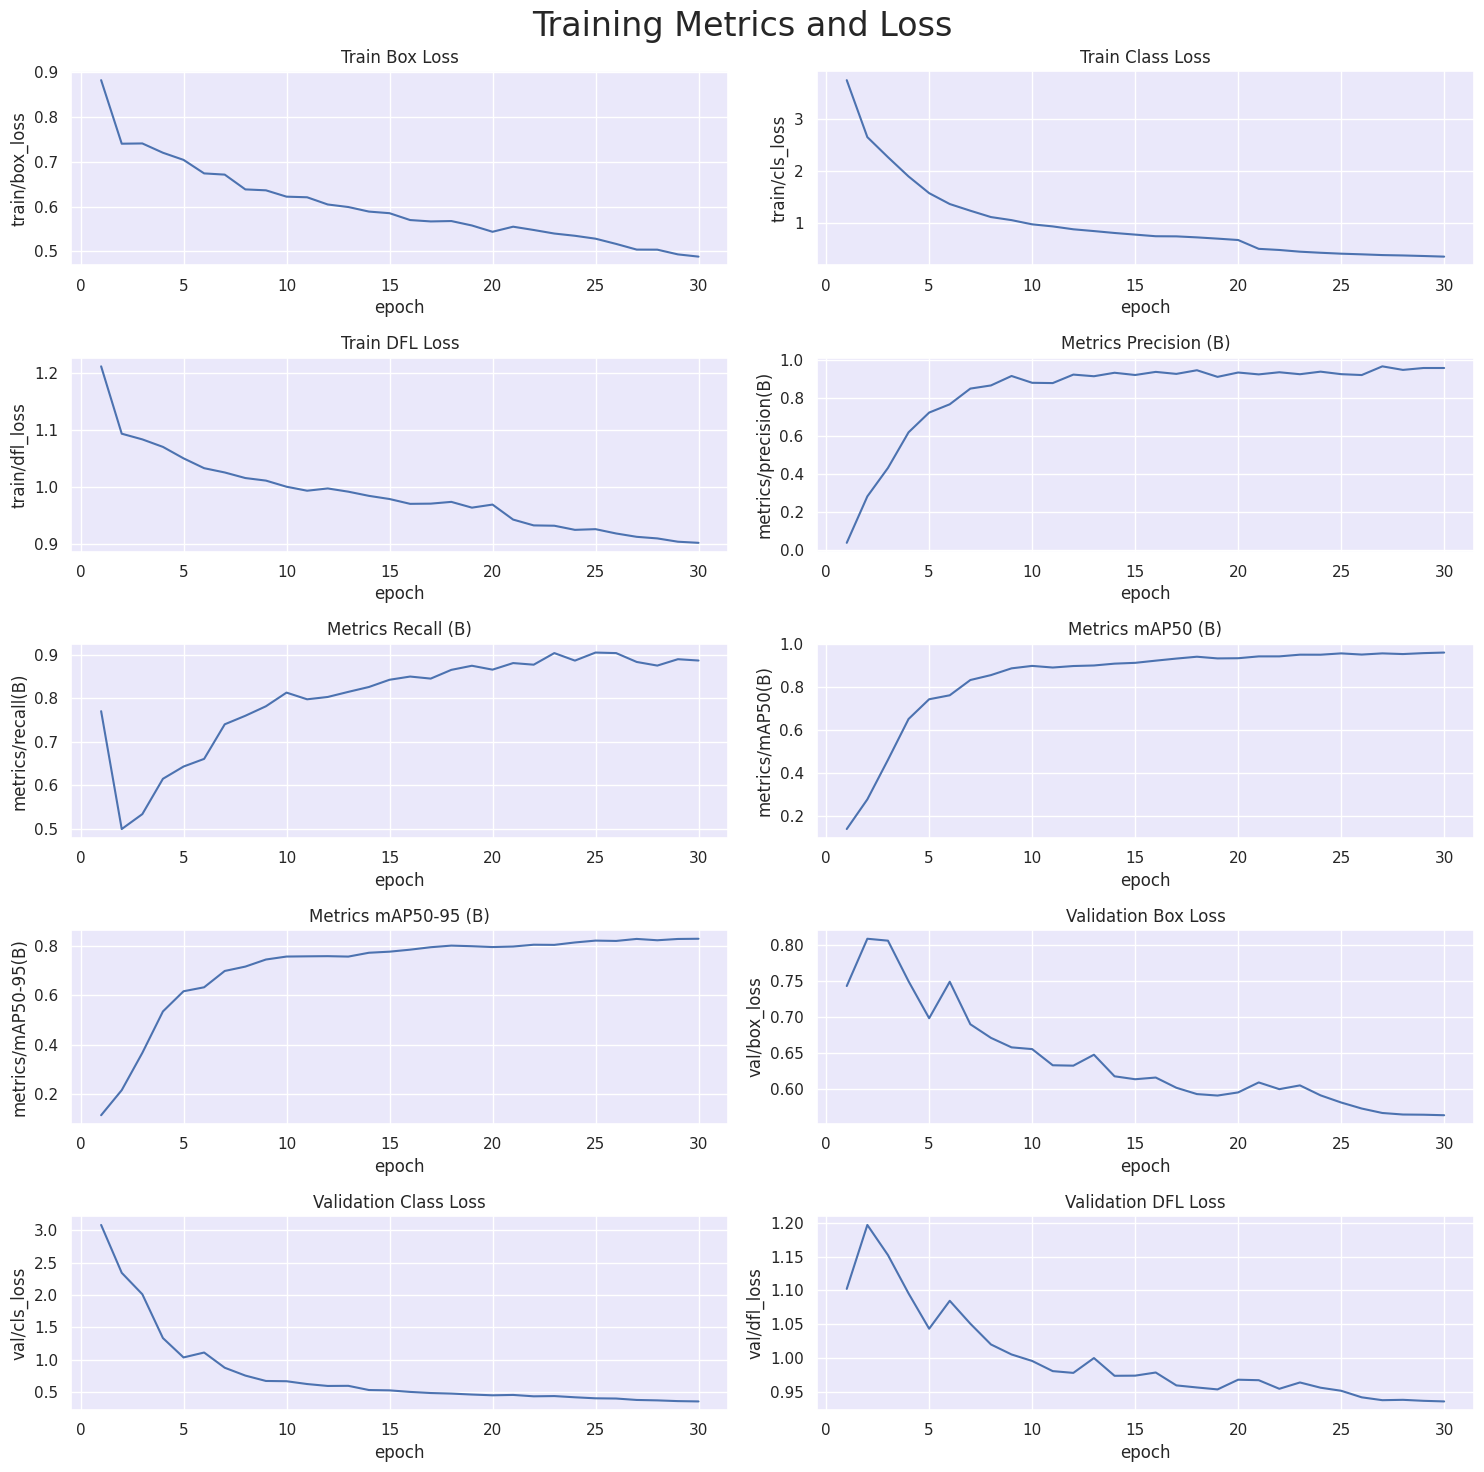

In [30]:
# Read the results.csv file as a pandas dataframe
Result_Final_model.columns = Result_Final_model.columns.str.strip()

# Create subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# Plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=Result_Final_model, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=Result_Final_model, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=Result_Final_model, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=Result_Final_model, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=Result_Final_model, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=Result_Final_model, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=Result_Final_model, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=Result_Final_model, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=Result_Final_model, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=Result_Final_model, ax=axs[4,1])

# Set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')


plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

### 4.3 테스트셋 기반의 검증 모델

In [8]:
# Loading the best performing model
Valid_model = YOLO('./runs/detect/train/weights/best.pt')

In [9]:
# Evaluating the model on the validset
metrics = Valid_model.val(split = 'val')

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 929.9±506.9 MB/s, size: 19.0 KB)
val: Scanning /content/car/valid/labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 801/801 1.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 6.2it/s 8.3s
                   all        801        944      0.956      0.887       0.96      0.828
           Green Light         87        122      0.905      0.703      0.832      0.503
             Red Light         74        108      0.912      0.671      0.832        0.5
       Speed Limit 100         52         52      0.957      0.942      0.987       0.88
       Speed Limit 110         17         17      0.763      0.882      0.952      0.865
       Speed Limit 120         60         60          1

In [10]:
# final results
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

precision(B):  0.9558577893817547
metrics/recall(B):  0.8873978602275512
metrics/mAP50(B):  0.9597823360649105
metrics/mAP50-95(B):  0.8281762212256195


### 4.4 테스트 이미지로 예측하기


0: 640x640 1 Speed Limit 100, 7.3ms
Speed: 1.7ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 60, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 70, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 80, 7.7ms
Speed: 4.1ms preprocess, 7.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 80, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 90, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 20, 7.5ms
Speed: 1.6ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 90, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inferenc

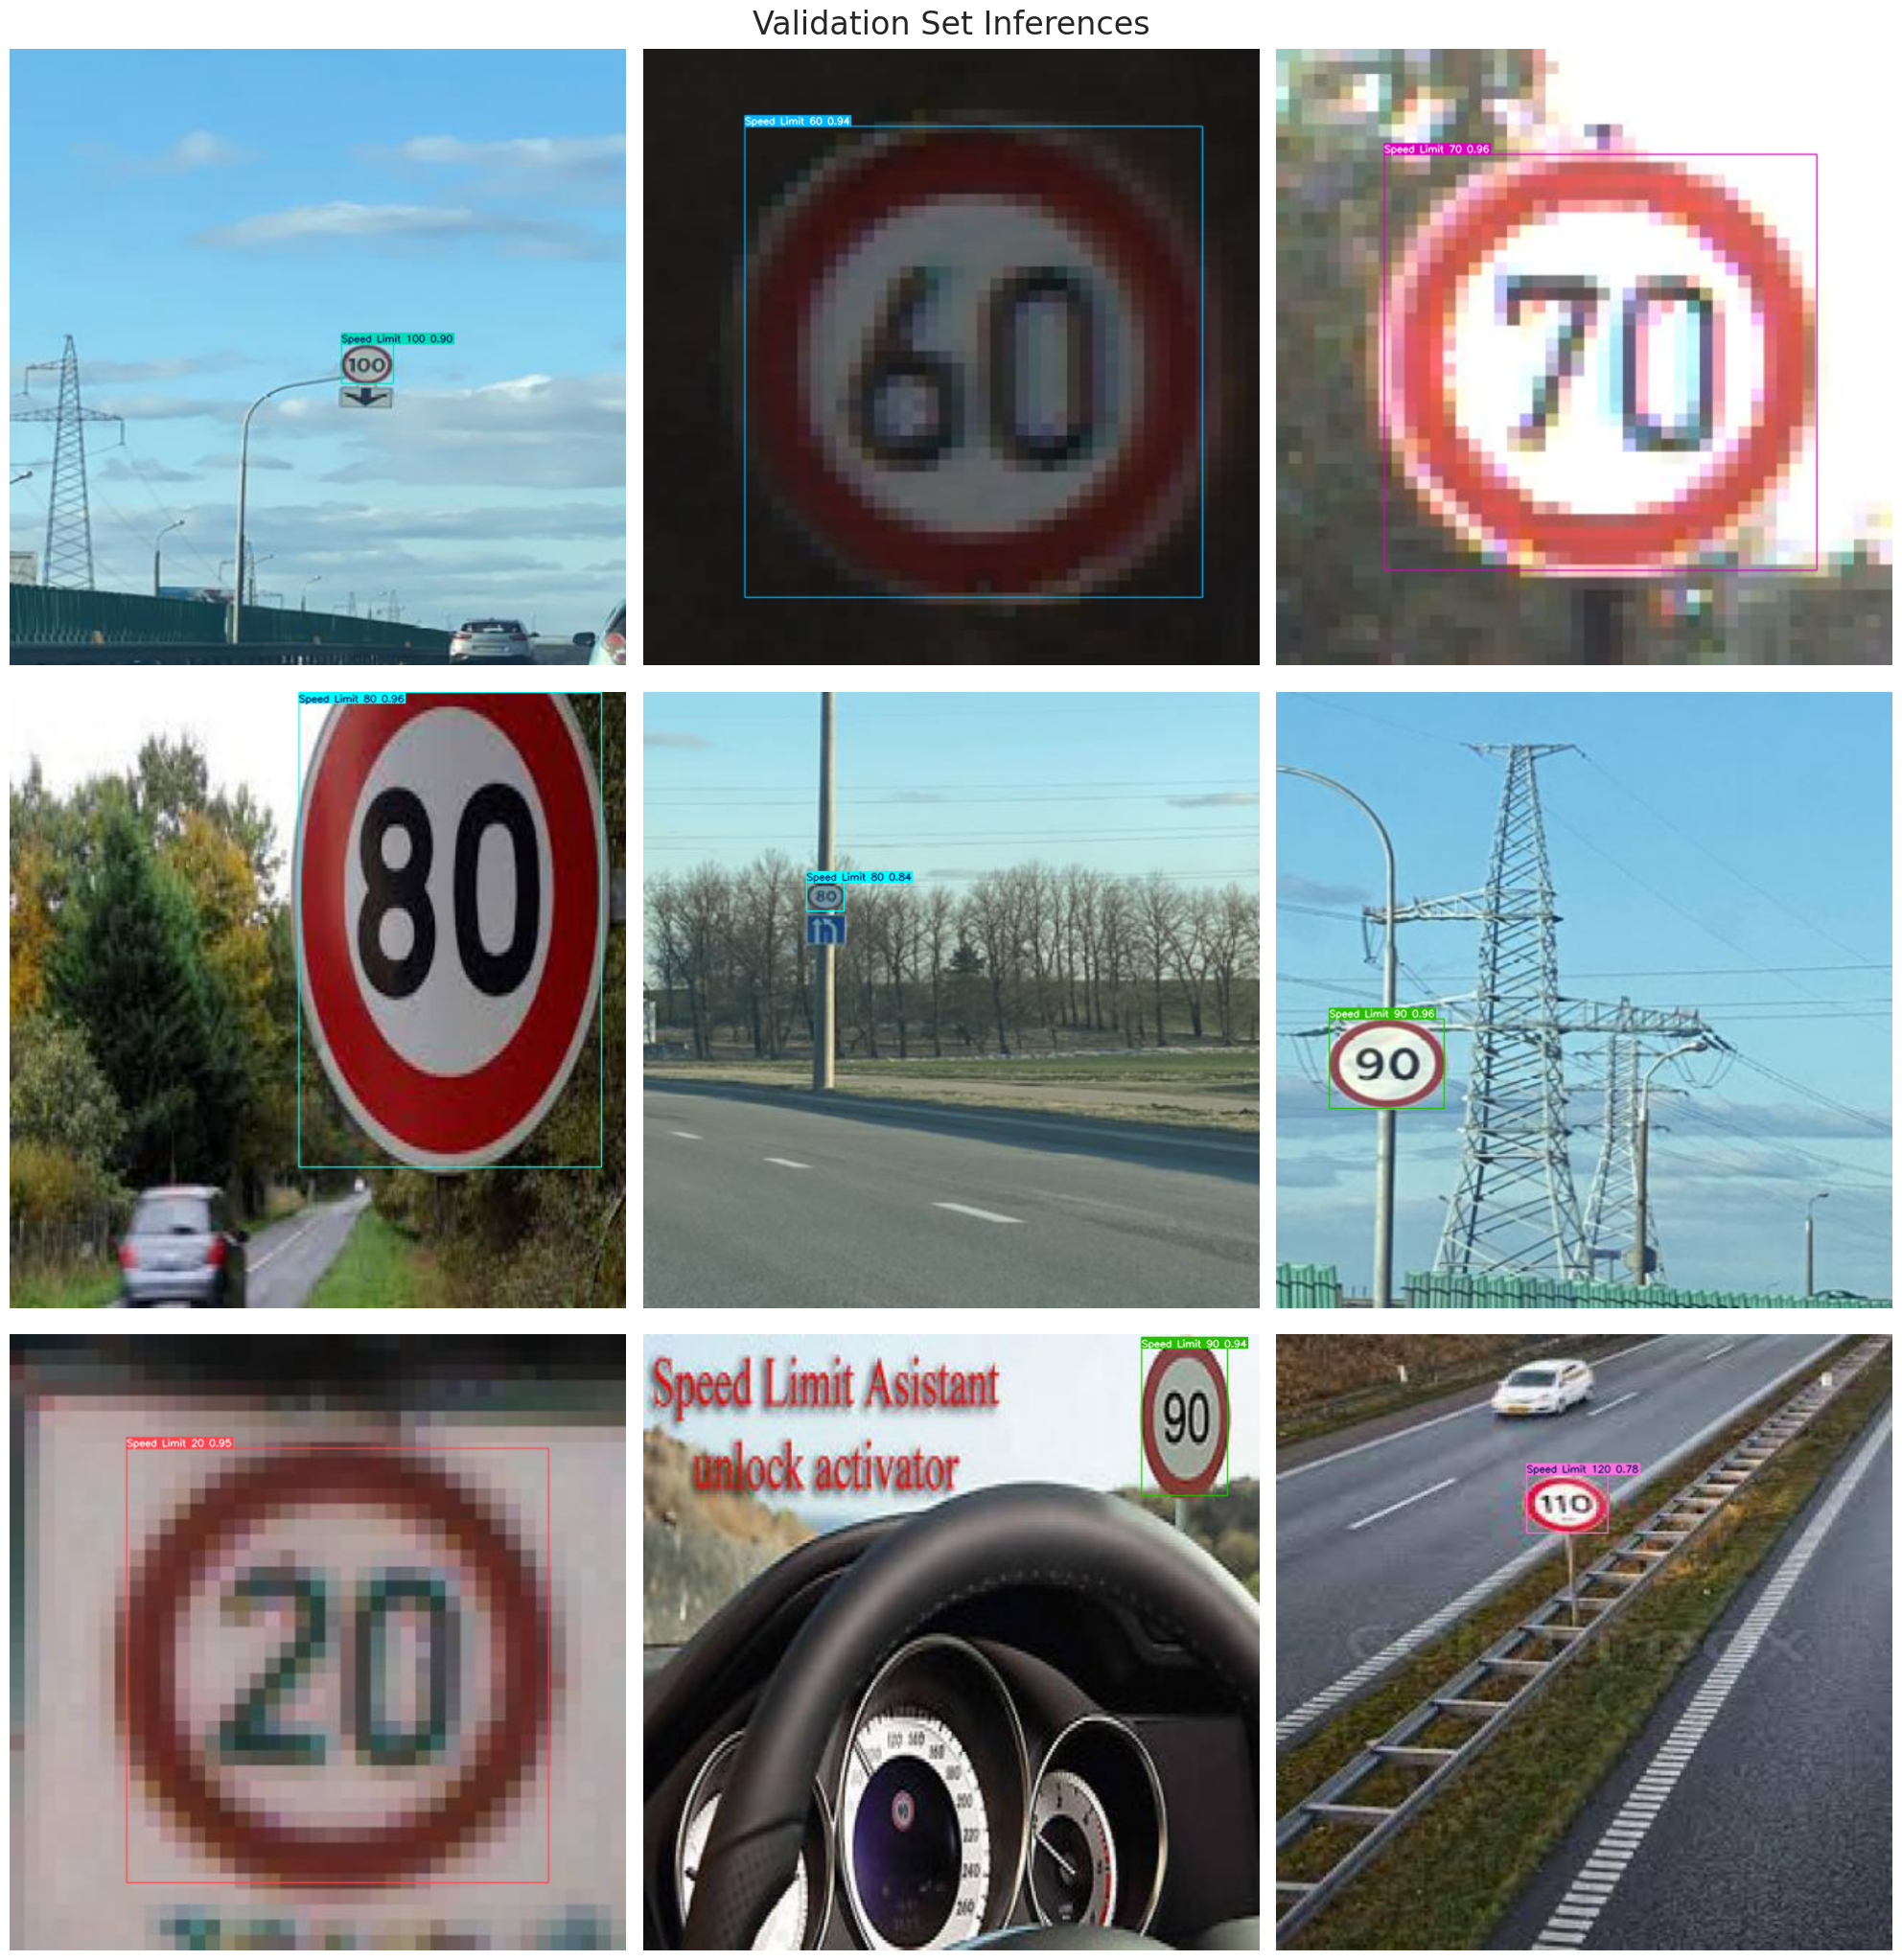

In [11]:
# Normalization function
def normalize_image(image):
    return image / 255.0

# Image resizing function
def resize_image(image, size=(640, 640)):
    return cv2.resize(image, size)

# Path to validation images
# dataset_path = '/kaggle/input/cardetection/car'  # Place your dataset path here
dataset_path = './car'  # Place your dataset path here
valid_images_path = os.path.join(dataset_path, 'test', 'images')

# List of all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Check if there are images in the directory
if len(image_files) > 0:
    # Select 9 images at equal intervals
    num_images = len(image_files)
    step_size = max(1, num_images // 9)  # Ensure the interval is at least 1
    selected_images = [image_files[i] for i in range(0, num_images, step_size)]

    # Prepare subplots
    fig, axes = plt.subplots(3, 3, figsize=(20, 21))
    fig.suptitle('Validation Set Inferences', fontsize=24)

    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            image_path = os.path.join(valid_images_path, selected_images[i])

            # Load image
            image = cv2.imread(image_path)

            # Check if the image is loaded correctly
            if image is not None:
                # Resize image
                resized_image = resize_image(image, size=(640, 640))
                # Normalize image
                normalized_image = normalize_image(resized_image)

                # Convert the normalized image to uint8 data type
                normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

                # Predict with the model
                results = Valid_model.predict(source=normalized_image_uint8, imgsz=640, conf=0.5)

                # Plot image with labels
                annotated_image = results[0].plot(line_width=1)
                annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
                ax.imshow(annotated_image_rgb)
            else:
                print(f"Failed to load image {image_path}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## **5. 사전학습된 YOLOv8로 동영상 교통 표지판 감지**

### 5.1 영상 인식 후 출력

In [18]:
!ffmpeg -y -loglevel panic -i ./video.mp4 output.mp4

**Tip:** The ultimate goal of training a model is to deploy it for real-world applications. Export mode in Ultralytics YOLOv8 offers a versatile range of options for exporting your trained model to different formats, making it deployable across various platforms and devices.


In [19]:
# Display the video
Video("./output.mp4", width=960, embed=True)

In [20]:
# Use the model to detect signs
Valid_model.predict(source="./video.mp4", show=True,save = True, stream=True)

<generator object BasePredictor.stream_inference at 0x7edcb56e4b80>

In [24]:
!ffmpeg -y -loglevel panic -i ./video.avi result_out.mp4

In [25]:
# Display the video
Video("./result_out.mp4", width=960, embed=True)

### 5.2 모델 저장

In [26]:
# Export the model
Valid_model.export(format='onnx')

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 19, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<=1.19.1', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 202ms
Prepared 6 packages in 7.52s
Installed 6 packages in 385ms
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.19.1
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.78

requirements: AutoUpdate success ✅ 9.0s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.78...
ONNX: export 

'runs/detect/train/weights/best.onnx'

In [17]:
!pwd

/content


In [28]:
!zip -r /content/yolo_result.zip /content/runs/

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/val3/ (stored 0%)
  adding: content/runs/detect/val3/val_batch1_labels.jpg (deflated 9%)
  adding: content/runs/detect/val3/BoxR_curve.png (deflated 5%)
  adding: content/runs/detect/val3/val_batch2_labels.jpg (deflated 12%)
  adding: content/runs/detect/val3/val_batch1_pred.jpg (deflated 9%)
  adding: content/runs/detect/val3/BoxPR_curve.png (deflated 8%)
  adding: content/runs/detect/val3/confusion_matrix.png (deflated 21%)
  adding: content/runs/detect/val3/confusion_matrix_normalized.png (deflated 16%)
  adding: content/runs/detect/val3/val_batch2_pred.jpg (deflated 12%)
  adding: content/runs/detect/val3/val_batch0_labels.jpg (deflated 9%)
  adding: content/runs/detect/val3/BoxF1_curve.png (deflated 5%)
  adding: content/runs/detect/val3/BoxP_curve.png (deflated 6%)
  adding: content/runs/detect/val3/val_batch0_pred.jpg (deflated 8%)
  adding: content/runs/detect/train/ (st